In [1]:
# Import the necessary packages
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Suppress specific future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Import the clean data
data = pd.read_pickle('source\data.pkl')

data.info()

# Copy of the original dataset for feature engineering and preprocessing
data_processed = data.copy()

# Drop unnecessary columns
data_processed = data_processed.drop(['AccID', 'birth_year', 'vehicleID', 'num_veh'], axis=1)

# Convert 'day', 'month', and 'time' to integers
data_processed['day'] = data_processed['day'].astype(int)
data_processed['month'] = data_processed['month'].astype(int)
data_processed['time'] = data_processed['time'].astype(int)

# Cyclical encoding for temporal features
data_processed['day_sin'] = np.sin(2 * np.pi * data_processed['day'] / 31)  
data_processed['day_cos'] = np.cos(2 * np.pi * data_processed['day'] / 31)

data_processed['month_sin'] = np.sin(2 * np.pi * data_processed['month'] / 12)
data_processed['month_cos'] = np.cos(2 * np.pi * data_processed['month'] / 12)

data_processed['time_sin'] = np.sin(2 * np.pi * data_processed['time'] / 86340000) 
data_processed['time_cos'] = np.cos(2 * np.pi * data_processed['time'] / 86340000)

data_processed.drop(columns=['day','month','time'],inplace=True)

# Selecting features and target variable
features_dummy = ['year', 'lum', 'atm_condition', 'collision_type',
       'route_category', 'traffic_regime', 'total_number_lanes',
       'reserved_lane_code', 'longitudinal_profile', 'plan',
       'surface_condition', 'infra', 'accident_situation',
       'traffic_direction', 'vehicle_category', 'fixed_obstacle',
       'mobile_obstacle', 'initial_impact_point', 'manv', 'motor', 'seat',
       'user_category', 'gender', 'reason_travel',
       'safety_equipment1']

# These features will be standardized
features_scaler = ['lat', 'long', 'upstream_terminal_number', 'distance_upstream_terminal', 'maximum_speed', 'age']

# These features are between -1 and 1 and do not need any standardazations. 
features_temporal = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'time_sin', 'time_cos']
target = 'gravity'

X = data_processed.drop(columns=[target])
y = data_processed[target]
y = y.astype(int)

X = pd.get_dummies(X, columns=features_dummy, drop_first=True)

# stratify will split the dataset according to the distribution of the classes to compensate for imbalanced datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardization: Fit only on the training data, then apply to both train and test
scaler = StandardScaler()
X_train[features_scaler] = scaler.fit_transform(X_train[features_scaler])
X_test[features_scaler] = scaler.transform(X_test[features_scaler])

# Check the dimensions
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447670 entries, 0 to 447669
Data columns (total 39 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   AccID                       447670 non-null  object 
 1   day                         447670 non-null  object 
 2   month                       447670 non-null  object 
 3   year                        447670 non-null  object 
 4   time                        447670 non-null  object 
 5   lum                         447670 non-null  object 
 6   atm_condition               447670 non-null  object 
 7   collision_type              447670 non-null  object 
 8   lat                         447670 non-null  float64
 9   long                        447670 non-null  float64
 10  route_category              447670 non-null  object 
 11  traffic_regime              447670 non-null  object 
 12  total_number_lanes          447670 non-null  object 
 13  reserved_lane_

Apply ML v5--------> 

In [2]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import numpy as np

# Define a function to train and evaluate the model
def train_and_evaluate(X_train_resampled, y_train_resampled, X_test, y_test, class_weight=None):
    # Initialize the XGBoost classifier
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    
    # Apply class weights if specified
    if class_weight:
        xgb_model.set_params(scale_pos_weight=class_weight)
    
    # Train the model
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on the test set
    y_pred = xgb_model.predict(X_test)
    
    # Generate and return the classification report
    return classification_report(y_test, y_pred)

# Original split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardization: Fit only on training data
scaler = StandardScaler()
X_train[features_scaler] = scaler.fit_transform(X_train[features_scaler])
X_test[features_scaler] = scaler.transform(X_test[features_scaler])

# Adjust the target variable `y` to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

--------> RandomOverSampler - BEST RESULT

In [3]:
ros = RandomOverSampler(random_state=42)
X_train_res_ros, y_train_res_ros = ros.fit_resample(X_train, y_train_adjusted)
report_ros = train_and_evaluate(X_train_res_ros, y_train_res_ros, X_test, y_test_adjusted)
print("RandomOverSampler Report:\n", report_ros)

C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


RandomOverSampler Report:
               precision    recall  f1-score   support

           0       0.76      0.79      0.77     37537
           1       0.16      0.56      0.25      2256
           2       0.41      0.51      0.45     13565
           3       0.72      0.51      0.60     36176

    accuracy                           0.63     89534
   macro avg       0.51      0.59      0.52     89534
weighted avg       0.67      0.63      0.64     89534



Feature Importance with XGBoost

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the numerical features for PCA
features_scaler = ['lat', 'long', 'upstream_terminal_number', 'distance_upstream_terminal', 'maximum_speed', 'age']

# Step 1: Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[features_scaler])
X_test_scaled = scaler.transform(X_test[features_scaler])

# Step 2: Initialize and Apply PCA
# Keeping enough components to explain 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 3: Transform PCA results into DataFrames for clarity
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Step 4: Concatenate PCA components with the rest of the data
# Drop the original features used for PCA and add the PCA components
X_train_final = pd.concat([X_train.drop(columns=features_scaler).reset_index(drop=True), X_train_pca_df], axis=1)
X_test_final = pd.concat([X_test.drop(columns=features_scaler).reset_index(drop=True), X_test_pca_df], axis=1)

# Check the dimensions of the final datasets
print(f"Shape of X_train after PCA: {X_train_final.shape}")
print(f"Shape of X_test after PCA: {X_test_final.shape}")


Shape of X_train after PCA: (358136, 211)
Shape of X_test after PCA: (89534, 211)


C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


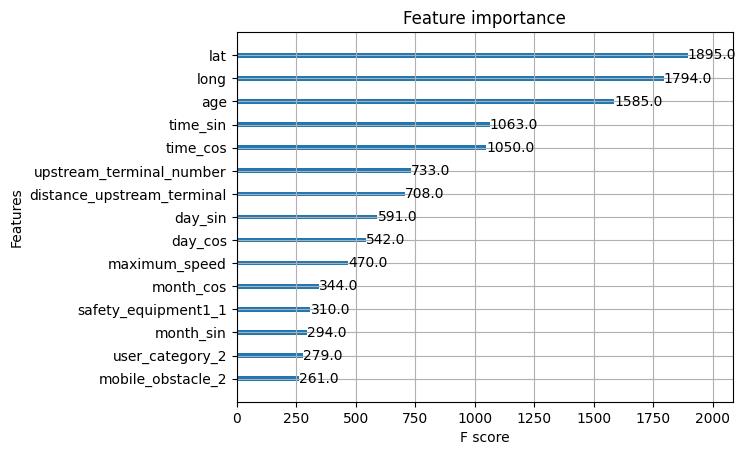

In [5]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_res_ros, y_train_res_ros)
plot_importance(xgb_model, max_num_features=15)  # Adjust number of features as needed
plt.show()


 SHAP explainer

In [9]:
from lime import lime_tabular

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_res_ros),
    feature_names=X_train.columns,
    class_names=[0, 1, 2, 3],
    mode='classification'
)

# Choose a test instance to explain
i = 0  # Index of the instance you want to explain
exp = explainer.explain_instance(X_test.iloc[i], xgb_model.predict_proba)

# Show the explanation
exp.show_in_notebook(show_table=True)


C:\Users\sd10725\AppData\Local\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\sd10725\AppData\Local\anaconda3\Lib\site-packages\shap\plots\_beeswarm.py:624: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


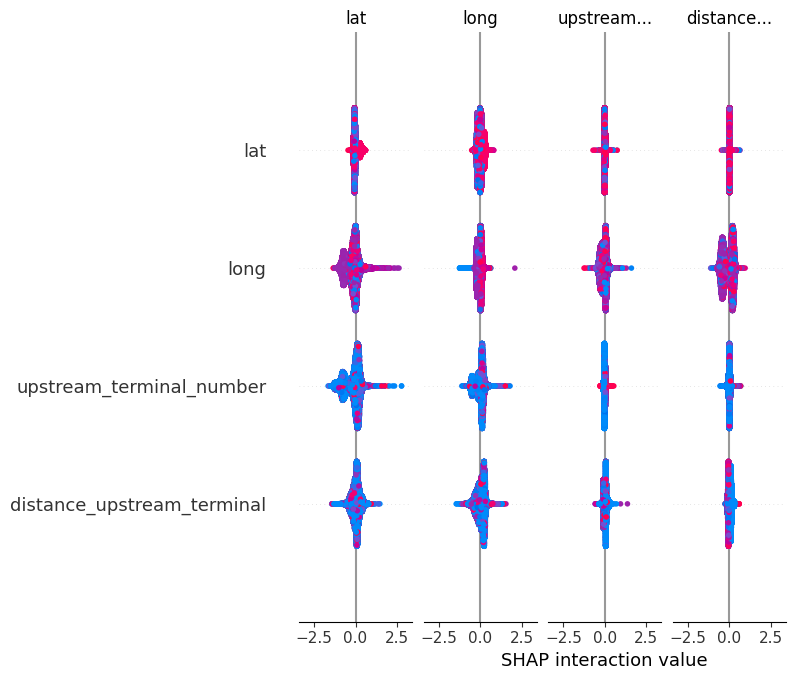

In [6]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance (global interpretability)
shap.summary_plot(shap_values, X_test, plot_type="bar")
